# AnyoneAI - Project II

# Making Predictions with NBA data

teamIn our first project, we learned how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using the Scikit Learn library

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## 1. Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")

Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

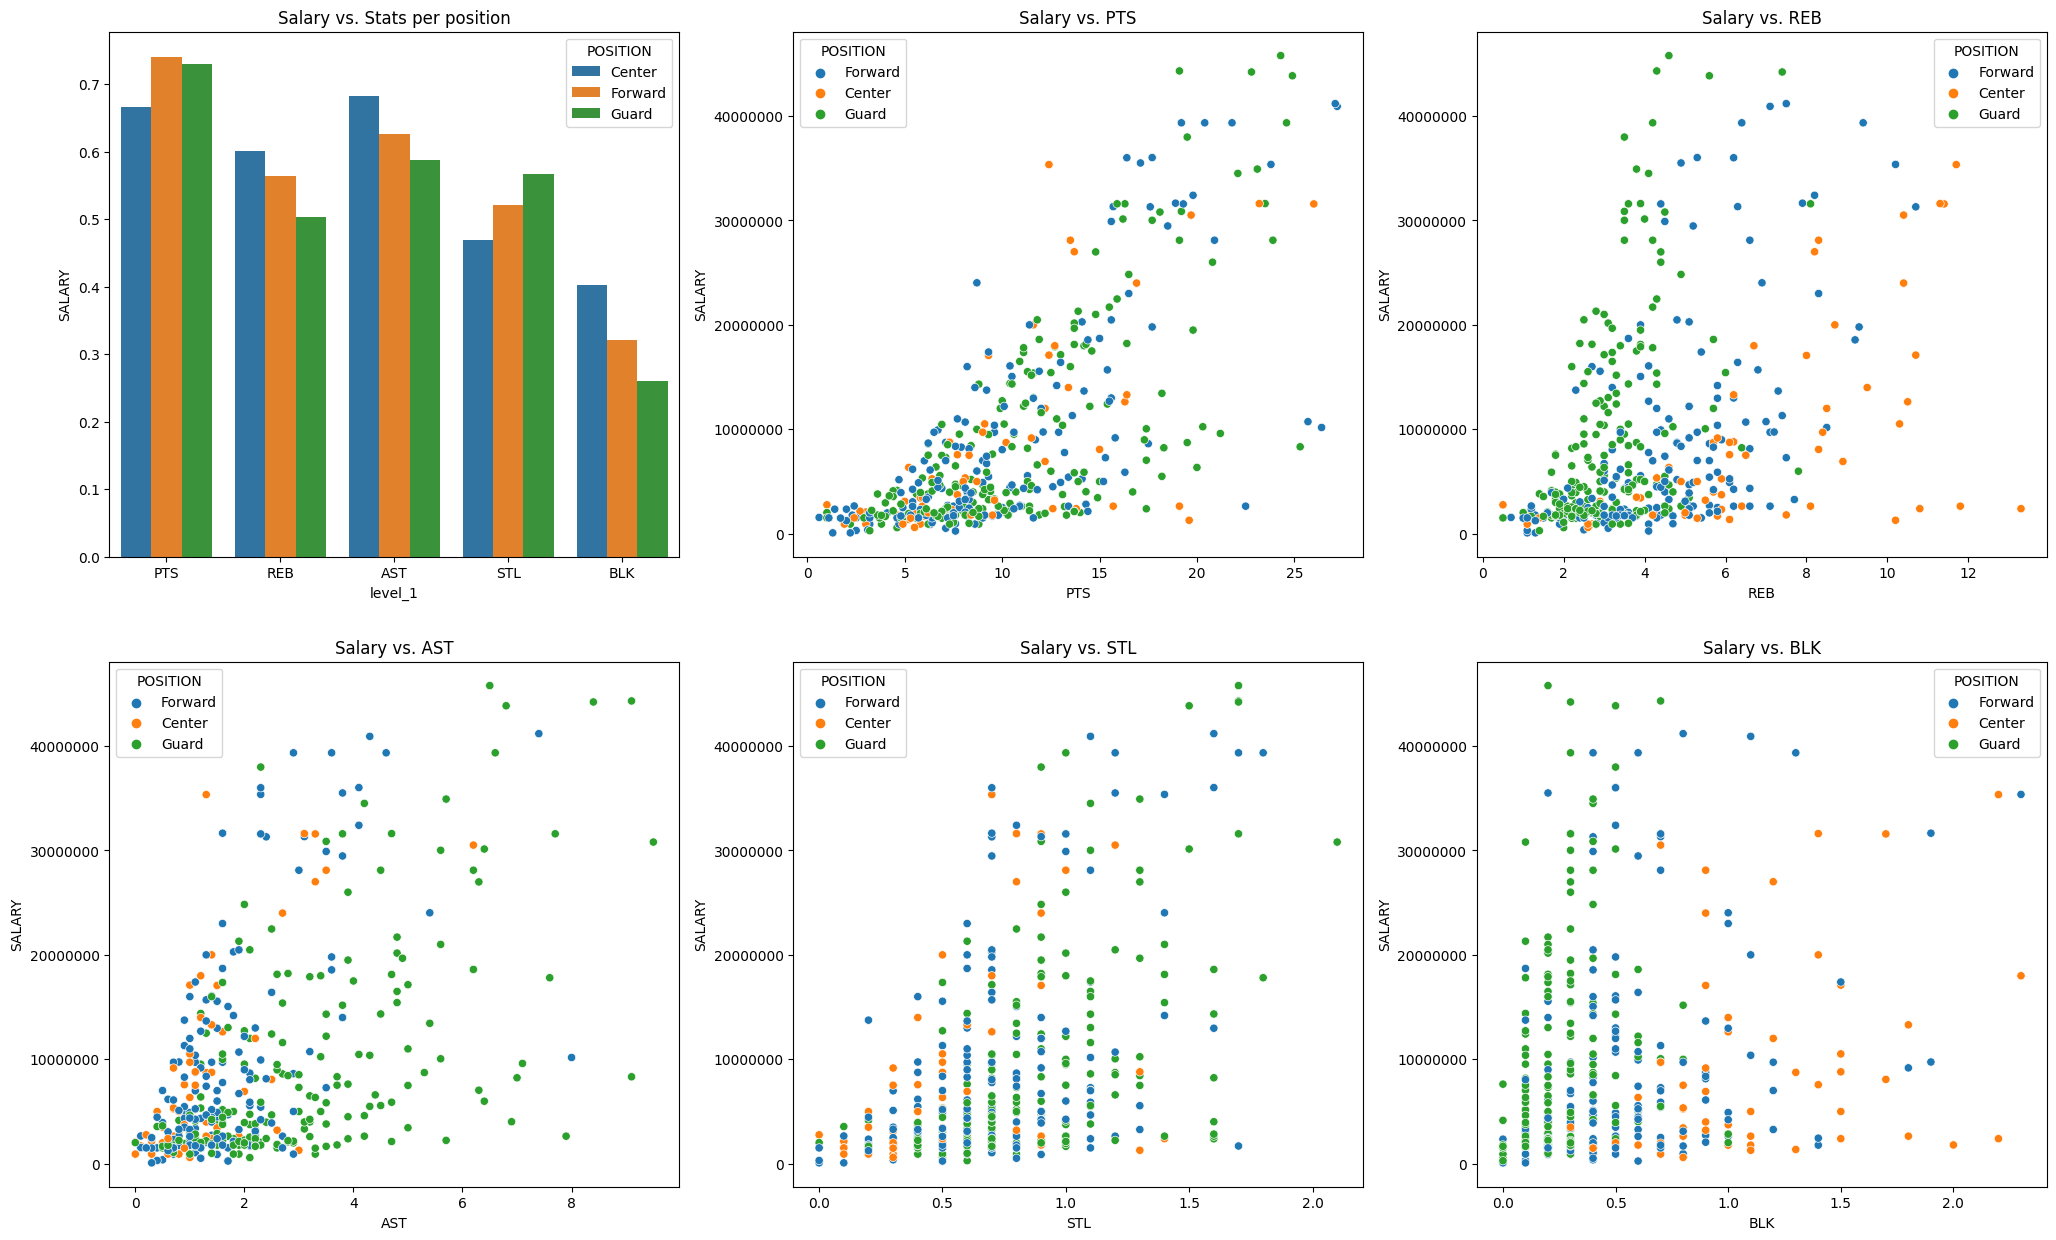

In [3]:
fig, ax = plt.subplots(2,3,figsize=(25,15))

# Dataframe for Salary vs Stats per position plot
a=data[["PTS", "REB", "AST","STL","BLK", "POSITION", "SALARY"]]
a=a.groupby(by="POSITION").corr()
b=a.T.iloc[-1].reset_index()
corr_salary_stats_pos=b[b["level_1"] != "SALARY"]

# Salary vs Stats per position
sns.barplot(corr_salary_stats_pos, x="level_1", y="SALARY", hue="POSITION", ax=ax[0][0])
ax[0][0].set_title("Salary vs. Stats per position")

# Salary vs "PTS", "REB", "AST","STL","BLK"
sns.scatterplot(data, y="SALARY", x=data["PTS"], ax=ax[0,1], hue="POSITION").ticklabel_format(style="plain")
ax[0][1].set_title("Salary vs. PTS")
sns.scatterplot(data, y="SALARY", x=data["REB"], ax=ax[0,2], hue="POSITION").ticklabel_format(style="plain")
ax[0][2].set_title("Salary vs. REB")
sns.scatterplot(data, y="SALARY", x=data["AST"], ax=ax[1,0], hue="POSITION").ticklabel_format(style="plain")
ax[1][0].set_title("Salary vs. AST")
sns.scatterplot(data, y="SALARY", x=data["STL"], ax=ax[1,1], hue="POSITION").ticklabel_format(style="plain")
ax[1][1].set_title("Salary vs. STL")
sns.scatterplot(data, y="SALARY", x=data["BLK"], ax=ax[1,2], hue="POSITION").ticklabel_format(style="plain")
ax[1][2].set_title("Salary vs. BLK")

plt.show()

1.2. What can we say about these distributions?

#### Answer:
This distributions show 2 facts:
1. Points is the most relevant factor for a players's salary
2. Some metrics have a greater on salary impact according to the players position

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

**Note:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

In [4]:
# TODO: Put here your features
X = data.drop(columns="SALARY")
# TODO: Put here your labels
y = data["SALARY"]

# TODO: Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

*Don't change anything in this cell, just make it run correctly*

In [5]:
if X.SEASON_EXP[322] == 7 and y[255] == 1517981:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

if X.shape == (429, 18) and y.shape == (429,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!
Success!


### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [6]:
class BaselineModel():
  """
  A baseline model that always returns the same value, the mean of the 
  players salary in the train data
  """
  
  def __init__(self):
    self.w0 = 0
  
  def fit(self, y_train):
    """
    Fit the training data. 
    
    Parameters
    ----------
    y_train: Union[pd.Series, np.ndarray]
        a pandas series or numpy array containing salary information
    """
    self.w0 = y_train.mean()
      
  
  def predict(self, X):
    """
    Predict salaries 
    
    Parameters
    ----------
    X: Union[pd.DataFrame, pd.Series, np.ndarray]
        a pandas series, dataframe or numpy array with the 
        
    Returns
    -------
    np.ndarray
        a numpy array of the same length as X, with all elements equal to 
        the mean salary calculated in fit()
    """
    return np.full(len(X), self.w0) 
      

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [7]:
baseline_model = BaselineModel()
baseline_model.fit(y_train=y_train)
baseline_mae = round(mean_absolute_error(y_test, baseline_model.predict(X=X_test)))
baseline_mae

7464645

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

In [8]:
def column_scaler(X_train_and_test, columns_to_scale, scaler):
  """
  Scales specified columns from train and test dataframes according to specified sklear scaler

  Parameters
  -
  X_train_and_test (list): containing train and test dataframes \n
  columns_to_scale (list): containing names of the columns to scale \n
  scaler (sklearn.preprocessing): the model used to do the scaling \n
  """

  for x in X_train_and_test:
    for column in columns_to_scale:
      x[column] = scaler.fit_transform(x[column].values.reshape(-1,1))

column_scaler([X_train, X_test], ["PTS"], StandardScaler())

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

In [9]:
default_sgdr = SGDRegressor(random_state=1)
default_sgdr.fit(X_train["PTS"].values.reshape(-1,1), y_train)
default_mae = round(mean_absolute_error(y_test, default_sgdr.predict(X_test["PTS"].values.reshape(-1,1))))
default_mae

4904933

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

### EXPLANATION
I created a function (hyperparameters_combinator()) that returns a list of dicts with all hyperparameters combination, that works for all model's hyperparameters

That list is used within a class (OptimizedRegressor()) that has as atributes the best model, the parameters used for that model, the best prediction made, and the evaluation metric used

On the next cell there's an example on how this works, but I'll use this class during the whole project, so it's tunned to work for all the models used during the project

In [10]:
class OptimizedRegressor():
  """
  Description of OptimizedRegressor

  Attributes:
    model (sklearn): best model trained
    params (dict): best hyperparameters from all the hyperparameters combinations provided 
    eval_metric (sklear.metric): used for determine the best model and hyperparameters
    prediction (float): value of the evaluation metric used

  Args:
    model (sklearn): the sklearn model to train

  """
  
  def __init__(self, model):
    self.model = model
    self.params = None
    self.eval_metric = None
    self.prediction = None    
  
  def fit_optimal(self, params, X_train, X_test, y_train, y_test, eval_metric):
    """
    Description of fit_optimal

    Args:
      params (list): list of lists with the parameters
      X_train (pandas.DataFrame): train set
      X_test (pandas.DataFrame): test set
      y_train (pandas.DataFrame): target train set
      y_test (pandas.DataFrame): target test set
      eval_metric (sklear.metrics): used for determine the best model and hyperparameters

    """
    model = self.model
    # If the best result of the metric is 0
    if eval_metric in [mean_absolute_error]:
      best_flag = 100000000
      for i in hyperparameters_combinator(params):
        fit_model = model(**i)
        fit_model.fit(X_train, y_train)
        flag = eval_metric(y_test, fit_model.predict(X_test))
        if flag < best_flag:
          self.model = fit_model
          self.eval_metric = flag
          self.params = i
          self.prediction = fit_model.predict(X_test)
          best_flag = flag
    
    # If the best result of the metric is 1
    if eval_metric in [accuracy_score, precision_score, recall_score, f1_score]:
      best_flag = 0
      for i in hyperparameters_combinator(params):
        fit_model = model(**i)
        fit_model.fit(X_train, y_train)
        flag = eval_metric(y_test, fit_model.predict(X_test))
        if flag > best_flag:
          self.model = fit_model
          self.eval_metric = flag
          self.params = i
          self.prediction = fit_model.predict(X_test)
          best_flag = flag

def hyperparameters_combinator(parameters: list) -> list:
  """Creates a list of dicts with all the combination for the selected parameters

  Args:
      parameters (list): list of lists of parameters; 
        each variable name of the list should be the same as 
        the name parameter for the model

  Returns:
      list: list of dictionaries of all combinations,
        containing as keys the parameter name and as value
        the parameter value for each combination 
  """
  
  ### Variables initialization
  hyp_param_combinations = []
  iter = None
  params_len = 1
  param_index = 0
  param_value_index = 0
  range_index = 0
  lenghts = []

  for i in parameters:
    lenghts.append(len(i))

  for i in lenghts:
    params_len *= i
  PARAMS_LEN = params_len
  iter = len(parameters) * PARAMS_LEN

  for i in range(PARAMS_LEN):
    hyp_param_combinations.append({})

  param_names = []
  for i in range(len(parameters)):
    param_names.append([k for k,v in globals().items() if id(v) == id(parameters[i])][0])


  ### Repeat lists
  # Consecutive times each value needs to be repeated
  repeat_range = []
  tot1 = 1
  for l in range(len(lenghts)):
    if l == len(lenghts) - 1:
      repeat_range.append(1)
    else:
      for a in lenghts[(l+1):]:
        tot1 *= a
      repeat_range.append(tot1)
      tot1 = 1
      
  # Times each list of values from a specific param needs to be repeated
  reiterate_range = []
  tot2 = 1
  for l in range(len(lenghts)):
    if l == 0:
      reiterate_range.append(1)
    else:
      for a in lenghts[:l]:
        tot2 *=  a
      reiterate_range.append(tot2)
      tot2 = 1

  saved_length = repeat_range[0]
  counter = repeat_range[0]
  count = 0

  ### Recursive combination loop
  # Iterates over each param, filling all the dicts with the param value before going to the next parameter
  while iter > 0:
    # Set the times to iterate over each parmeter
    for x in range(reiterate_range[param_index]):
      # The number to append
      num = parameters[param_index][param_value_index]
      
      # Appends a new dict entry into one of the dicts of the combinations list
      hyp_param_combinations[PARAMS_LEN - params_len][param_names[param_index]] = num
      
      # Control
      iter -= 1
      count -= 1
      params_len -= 1
      repeat_range[range_index] -= 1
      
      # If true, changes to the next value of the same parameter
      if repeat_range[range_index] == 0:
        repeat_range[range_index] = saved_length
        param_value_index += 1
        
        # If true, changes to the first value of the same parameter
        if count == 0:
          param_value_index = 0
          count = counter

    # Changes the parameter, reset all values, and checks if compleated
    if params_len == 0:
      # Changes the parameter
      range_index += 1
      param_index += 1
      
      # If True, all the combinations are compleated, so breaks the loop
      if range_index == len(reiterate_range):
        break
      
      # Reset values
      param_value_index = 0
      params_len = PARAMS_LEN
      counter = PARAMS_LEN // reiterate_range[range_index]
      count = counter
      saved_length = repeat_range[range_index]
      
  return hyp_param_combinations

In [ ]:
# Example list of hyperparameters values
max_iter = [1000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]
alpha = [0.0001, 0.001, 0.01, 0.1]
power_t = [0.2, 0.5]
random_state = [1]
params = [max_iter, alpha, eta0, power_t, random_state]

op_sdgr = OptimizedRegressor(SGDRegressor)
op_sdgr.fit_optimal(params, X_train["PTS"].values.reshape(-1,1), X_test["PTS"].values.reshape(-1,1), y_train, y_test, mean_absolute_error)

In [12]:
print(f"Hyperparameters: {op_sdgr.params}")
print(f"MAE: {round(op_sdgr.eval_metric)}")

Hyperparameters: {'max_iter': 1000, 'alpha': 0.1, 'eta0': 0.0001, 'power_t': 0.2, 'random_state': 1}
MAE: 4867287


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [13]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {op_sdgr.eval_metric}")

Mean Absolute Error for each model:
Baseline: 7464645
Default SGDRegressor: 4904933
Best SGDRegressor: 4867287.196498745


### Multivariable Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index) and name it mv_regression_df:

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [14]:
# Complete here
mv_regression_df = data.copy().set_index(keys="PERSON_ID")[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]]
mv_regression_df.head()

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,SALARY
PERSON_ID,,,,,,,,
1630173,7.2,5.1,0.8,0.5,2,Forward,20,2711280
203500,9.3,8.0,1.5,0.9,9,Center,12,17073171
1628389,13.5,8.3,3.5,0.9,5,Center,14,28103550
1630583,4.1,2.7,0.7,0.3,1,Forward,30,1994520
200746,19.1,8.1,1.9,1.1,16,Center,2,2641691


*Don't change anything in this cell, just make it run correctly*

In [15]:
if mv_regression_df.shape == (429, 8):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


#### Feature Engineering

1.11. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [16]:
# Params
bins=[0,1,15,30,60]
labels=["undrafted", "firstround_lottery", "firstround_non_lottery", "second_round"]

# "Undrafted" to 0.1, so it can be binned into a category
mv_regression_df["DRAFT"] = pd.cut(mv_regression_df["DRAFT_NUMBER"].apply(lambda x: 0.1 if(x == "Undrafted") else x).astype(float), bins=bins, labels=labels)
mv_regression_df.drop(columns="DRAFT_NUMBER", inplace=True)

*Don't change anything in this cell, just make it run correctly*

In [17]:
if mv_regression_df["DRAFT"].iloc[34] == 'firstround_lottery' and mv_regression_df["DRAFT"].iloc[105] == 'second_round':
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.12. Encode the categorical features: DRAFT, POSITION

In [18]:
mv_regression_df = pd.get_dummies(mv_regression_df, columns=["DRAFT", "POSITION"])

*Don't change anything in this cell, just make it run correctly*

In [19]:
if mv_regression_df["DRAFT_firstround_non_lottery"].iloc[134] == 1 and mv_regression_df["POSITION_Forward"].iloc[205] == 0:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


#### Modeling

1.13. Split the dataset into train and test. 


**Note 1:** Before using scikit-learn `train_test_split()`, separate your dataframe into features and labels. Assign your features to `X` variable and labels to `y`.

**Note 2:** Remember to drop `DRAFT_NUMBER` column if you haven't done that before

In [20]:
# Put here your features
X = mv_regression_df.drop(columns="SALARY")
# Put here your labels
y = mv_regression_df["SALARY"]

# Now use train_test_split()
X_train_mv, X_test_mv, y_train_mv, y_test_mv = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

*Don't change anything in this cell, just make it run correctly*

In [21]:
if X.BLK.iloc[353] == 0.1 and y.iloc[400] == 8729020:
  print('Success!')
else:
  raise ValueError('The draft categories are incorrect, please review your function')

Success!


1.14. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next).

In [22]:
column_scaler([X_train_mv, X_test_mv], ["PTS", "REB", "AST", "BLK", "SEASON_EXP"], MinMaxScaler())

1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [ ]:
max_iter = [1000, 1000000]
eta0 = [0.0001, 0.001, 0.01, 0.1]
alpha = [0.0001, 0.001, 0.01, 0.1]
power_t = [0.25, 0.5, 0,75]
random_state = [1]
params = [max_iter, alpha, eta0, power_t, random_state]

op_sdgr_mv = OptimizedRegressor(SGDRegressor)
op_sdgr_mv.fit_optimal(params, X_train_mv, X_test_mv, y_train_mv, y_test_mv, mean_absolute_error)

In [24]:
print(f"Hyperparameters: {op_sdgr_mv.params}")
print(f"MAE: {op_sdgr_mv.eval_metric}")

Hyperparameters: {'max_iter': 1000000, 'alpha': 0.01, 'eta0': 0.0001, 'power_t': 0, 'random_state': 1}
MAE: 4746241.002876243


1.16. How did the model performed compared to our univariate models? 

#### Answer:
The change wasn't significant

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [25]:
max_depth = [2,3,4,5,6,7,8,9, 10, 15, 20, 50]
min_samples_leaf = [2, 3, 4, 5, 6, 7, 8, 10, 20, 50]
max_features = [5, 10, 11, 12, 13, 14, 15, 16, 20, 25]
random_state = [1]
params = [max_depth, min_samples_leaf, max_features, random_state]

op_tree_regressor = OptimizedRegressor(DecisionTreeRegressor)
op_tree_regressor.fit_optimal(params, X_train_mv, X_test_mv, y_train_mv, y_test_mv, mean_absolute_error)

In [26]:
print(f"Hyperparameters: {op_tree_regressor.params}")
print(f"MAE: {op_tree_regressor.eval_metric}")

Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 12, 'random_state': 1}
MAE: 2994981.6633798885


1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

In [27]:
print(f"Baseline: {baseline_mae}")
print(f"Default SGDR (one variable): {default_mae}")
print(f"Best SGDR (one variable): {op_sdgr.eval_metric}")
print(f"Best SGDR (multivariable): {op_sdgr_mv.eval_metric}")
print(f"Decision Tree (multivariable): {op_tree_regressor.eval_metric}")

Baseline: 7464645
Default SGDR (one variable): 4904933
Best SGDR (one variable): 4867287.196498745
Best SGDR (multivariable): 4746241.002876243
Decision Tree (multivariable): 2994981.6633798885


### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

#### Answer:
The tree model worked way better than the linear ones. Maybe because it could pick better the impact of certain features (like poits per game).

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

#### Answer:
It'll be possible to try different models, improve on the feature engineering, or just tryout more hyperparameters combinations (which will require more time or more computing power)

## 2. Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1983 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1983_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [28]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1983_2017_dataset.csv", index_col=0)

In [29]:
print("Number of rows:",len(all_nba_df))
print("Numbe of seasons:",len(all_nba_df["season"].unique()))
print("Number of unique players:",len(all_nba_df["player_id"].unique()))
print(f'All-NBA selected: {len(all_nba_df["all_nba"][all_nba_df["all_nba"] == 1])}')
print(f'All-NBA non selected: {len(all_nba_df["all_nba"][all_nba_df["all_nba"] == 0])}')

Number of rows: 14825
Numbe of seasons: 39
Number of unique players: 2718
All-NBA selected: 496
All-NBA non selected: 14329


### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'.

**Note:** Assign your features to `X` variable and labels to `y`.



In [30]:
all_nba_df.head(3)

,season_id,player_id,player_season,player,season,season_start,team,games,gamesstarted,mp,...,2p_perc,ft_perc,trb,ast,stl,blk,tov,pf,pts,all_nba
0,0,0,1,Alaa Abdelnaby,1990-91,1990,POR,43,0,6.7,...,0.474,0.568,2.1,0.3,0.1,0.3,0.5,0.9,3.1,0
1,1,0,2,Alaa Abdelnaby,1991-92,1991,POR,71,1,13.2,...,0.493,0.752,3.7,0.4,0.4,0.2,0.9,1.9,6.1,0
2,2,0,3,Alaa Abdelnaby,1992-93,1992,TOT,75,52,17.5,...,0.519,0.759,4.5,0.4,0.3,0.3,1.3,2.5,7.7,0


In [31]:
# Put here your features
X = all_nba_df[['team', 'games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']]
# Put here your labels
y = all_nba_df["all_nba"]

# Now use train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=1, stratify=y)

*Don't change anything in this cell, just make it run correctly*

In [32]:
if X.shape == (14825, 15) and y.shape == (14825,):
  print('Success!')
else:
  raise ValueError('Your features/labels shape is incorrect, please review your code')


Success!


### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

In [33]:
def baseline_model(X_train):
  """ A baseline model that always predicts that the player was not selected (0)

  Parameters
  ---
  X_train (pandas.Series, pandas.DataFrame): DataFrame that the model will use to make the prediction

  Returns
  ---
  np.array: prediction
  """
  return np.full(len(X_train), 0)

accuracy_score(y_train, baseline_model(X_train))

0.9665261382799325

2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

In [34]:
# Accuracy isn't probably a good metric, as it'll have a high value even if nothing is predicted at all

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place)

In [35]:
column_scaler([X_train, X_test], ['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'], RobustScaler())

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

In [36]:
default_logistic_regressor = LogisticRegression(random_state=1)
default_logistic_regressor.fit(X_train.drop(columns="team"), y_train)
classification_baseline_prediction = default_logistic_regressor.predict(X_test.drop(columns="team"))

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

In [37]:
print("Accuracy:",accuracy_score(y_test, classification_baseline_prediction))
print("Precision:",precision_score(y_test, classification_baseline_prediction))
print("Recall",recall_score(y_test, classification_baseline_prediction))
print("F1",f1_score(y_test, classification_baseline_prediction))

Accuracy: 0.9804384485666104
Precision: 0.7662337662337663
Recall 0.5959595959595959
F1 0.6704545454545454


From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

In [38]:
X_train = pd.get_dummies(X_train, columns=["team"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["team"], drop_first=True)

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

In [39]:
tol = [0.00001, 0.1, 0.001, 0.0001,]
C = [0.3, 0.5, 0.7, 1.0]
max_iter = [100, 200, 500, 1000]
params=[tol,C,max_iter]

op_logistic = OptimizedRegressor(LogisticRegression)
op_logistic.fit_optimal(params, X_train, X_test, y_train, y_test, f1_score)
print("Hyperparameters:",op_logistic.params)

Hyperparameters: {'tol': 1e-05, 'C': 0.3, 'max_iter': 100}


In [40]:
print("F1:",op_logistic.eval_metric)
print("Precision:",precision_score(y_test, op_logistic.prediction))
print("Recall:",recall_score(y_test, op_logistic.prediction))

F1: 0.6744186046511629
Precision: 0.7945205479452054
Recall: 0.5858585858585859


#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [41]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

In [42]:
column_scaler([all_nba_2018_df],['games', 'gamesstarted', 'mp', 'fg_perc', '3p_perc', '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'], RobustScaler())
all_nba_2018_df = pd.get_dummies(all_nba_2018_df, columns=["team"], drop_first=True)
cols_to_include = []

for col in X_train.columns:
  if col[:4] == "team":
    if col not in all_nba_2018_df.columns:
      cols_to_include.append(col)

for col in cols_to_include:
  all_nba_2018_df[col] = 0

all_nba_2018_df = all_nba_2018_df.drop(columns=["season_id", "player_id", "player_season", "player", "season", "season_start"])

# Set the same column order between dataframes
all_nba_2018_df = all_nba_2018_df[X_train.columns]

*Don't change anything in this cell, just make it run correctly*

In [43]:
if all_nba_2018_df.shape == (530, 54):
  print('Success!')
else:
  raise ValueError('The shape is incorrect, please review your function')

Success!


2.11. Predict and evaluate the model using precision, recall and f1 score. 

In [44]:
prediction = op_logistic.model.predict(all_nba_2018_df)
print("F1:",f1_score(all_nba_2018_selections["all_nba"], prediction))
print("Precision:",precision_score(all_nba_2018_selections["all_nba"], prediction))
print("Recall:",recall_score(all_nba_2018_selections["all_nba"], prediction))

F1: 0.7692307692307693
Precision: 0.625
Recall: 1.0


2.12. Analyze the results, what do you think it is happening?

#### Answer:
As there are just 15 players with 1 in all_nba, probably the model catches all of them, which makes recall equal to 1. Nonetheless, Precision and F1 point out that there where more players selected than it should.

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

In [45]:
prediction_proba = op_logistic.model.predict_proba(all_nba_2018_df)[:,1]
all_nba_2018_selections["all_nba_proba"] = prediction_proba.round(decimals=3)

2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

In [46]:
predictions_15_df = all_nba_2018_selections.sort_values(by="all_nba_proba", ascending=False)[:15]
predictions_15_df

,player_id,player,all_nba,all_nba_proba
5604,1024,James Harden,1,0.999
453,83,Giannis Antetokounmpo,1,0.999
6857,1240,LeBron James,1,0.996
3401,587,Anthony Davis,0,0.987
14479,2648,Russell Westbrook,1,0.983
4145,740,Joel Embiid,1,0.977
3908,695,Kevin Durant,1,0.966
14027,2572,Nikola Vucevic,0,0.930
4895,884,Paul George,1,0.928
13673,2501,Karl-Anthony Towns,0,0.920


2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

In [47]:
players_selected = all_nba_2018_selections[all_nba_2018_selections["all_nba"] == 1]["player"]
players_missing = players_selected[~players_selected.isin(predictions_15_df["player"])]
players_not_selected = predictions_15_df[predictions_15_df["all_nba"] == 0]["player"]

print(f"Players selected (true positives):\n{list(players_selected)}\n")
print(f"Players missing (true negatives):\n{list(players_missing)}\n")
print(f"Players not selected (false positives):\n{list(players_not_selected)}")

Players selected (true positives):
['Giannis Antetokounmpo', 'Stephen Curry', 'Kevin Durant', 'Joel Embiid', 'Paul George', 'Rudy Gobert', 'Blake Griffin', 'James Harden', 'Kyrie Irving', 'LeBron James', 'Nikola Jokic', 'Kawhi Leonard', 'Damian Lillard', 'Kemba Walker', 'Russell Westbrook']

Players missing (true negatives):
['Rudy Gobert', 'Kyrie Irving', 'Kemba Walker']

Players not selected (false positives):
['Anthony Davis', 'Nikola Vucevic', 'Karl-Anthony Towns']


2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [48]:
class AllNbaSingleSeasonClassifier():
  def __init__(self, model):
    """
    Class constructor
    
    Parameters
    ----------
    model: BaseEstimator
      a Scikit learn estimator
    """
    self._model = model
      
  def predict(self, X):
    """
    Predicts all nba selections. This classifier will limit the number
    of positive instances to 15
    
    Parameters
    ----------
    X: pd.DataFrame
      a dataframe with the players data
        
    Returns
    -------
    np.ndarray
      An array of the same length as y, with 15 true results based on the players with most probabilities of
      beign selected
    """
    prediction = self._model.predict_proba(X)[:,1].round(decimals=3)
    bool_array = np.isin(prediction, np.array(predictions_15_df["all_nba_proba"]))
    return bool_array

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

In [49]:
prediction = AllNbaSingleSeasonClassifier(op_logistic.model).predict(all_nba_2018_df)
print(f1_score(all_nba_2018_selections["all_nba"], prediction))
print(precision_score(all_nba_2018_selections["all_nba"], prediction))
print(recall_score(all_nba_2018_selections["all_nba"], prediction))

0.8000000000000002
0.8
0.8


#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

My first hypothesis was that it didn't take into account the limit of the positions for the players. The next cell shows the predicted positions vs the positions required

In [50]:
print(f'Positions predicted: {dict(data[data["PLAYER_NAME"].isin(predictions_15_df["player"])]["POSITION"].value_counts())}')
print(f'Actual positions: {dict(data[data["PLAYER_NAME"].isin(all_nba_2018_selections[all_nba_2018_selections["all_nba"] == 1]["player"])]["POSITION"].value_counts())}')

Positions predicted: {'Forward': 7, 'Guard': 4, 'Center': 4}
Actual positions: {'Forward': 6, 'Guard': 6, 'Center': 3}


To solve this, I created a function to pick the best players for each category until the category is completed. 

The problem is that, even if there are changes on the players that the first prediction showed, this didn't changed the predicted players as their predic_proba value was to high.

Other problems are explored on the next point.

In [51]:
all_nba_players_prediction = []
prediction = op_logistic.model.predict_proba(all_nba_2018_df)[:,1].round(decimals=3)

new_df = pd.merge(data.rename(columns={"PLAYER_NAME": "player"}), all_nba_2018_selections,on="player")
new_df = new_df.sort_values(by="all_nba_proba", ascending=False)
count = 15
completed_positions = []

center_counter = 3
guard_counter = 6
forward_counter = 6

for i in new_df["player"]:
  player_position = new_df[new_df["player"] == i]["POSITION"].iloc[0]
  if count > 0:
    if player_position not in completed_positions:
      if player_position == "Center":
        all_nba_players_prediction.append(i)
        center_counter -= 1
        count -= 1
      elif player_position == "Forward":
        all_nba_players_prediction.append(i)
        guard_counter -= 1
        count -= 1
      elif player_position == "Guard":
        all_nba_players_prediction.append(i)
        forward_counter -= 1
        count -= 1
  if center_counter == 0:
    completed_positions.append("Center")
  elif guard_counter == 0:
    completed_positions.append("Guard")
  elif forward_counter == 0:
    completed_positions.append("Forward")   

print("New player:")
for i in all_nba_players_prediction:
  if i not in list(predictions_15_df["player"]):
    print(i)

print("\nMissing players:")
for i in all_nba_players_prediction:
  if i not in list(players_selected):
    print(i)

New player:
Kemba Walker

Missing players:
Anthony Davis
Nikola Vucevic
Karl-Anthony Towns


2.19. What do you think we could do to improve our model?

#### Answer:
To improve upon my first model I tried changing the scaler and the stratify parameter. 
- Using RobustScaler it increased by 0.2 the prediction. 
- Using stratify=y increased the difference between players on the predic_proba() results

Also, I tried creating the function showed on the previous point, but it didn't work

Probably tryiing anothe model could show a better performance. 

Finally, for selecting the players on all-nba there's the public imput, that maybe is missing on this data.

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

## 3. Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [52]:
class LinearRegressor:
  """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
  
  def __init__(self, epochs: int, learning_rate: float):
    """
    Class constructor
    
    Parameters
    ----------
    epochs: int
      number of epochs to run gradient descent
    learning_rate: float
      rate of update of the gradients
    """


  def _gradient_descent():
    """
    Gradient descent algorithm
    """


  def fit(self, X, y):
    """
    Fit the model according to the given training data.
    
    Parameters
    ----------
    X: np.ndarray
    y: np.ndarray
    """
            
  def predict(self, X):
    """
    Predict
    
    Parameters
    ----------
    X: np.ndarray
    
    Returns
    -------
    np.ndarray
      array with predictions
    """


3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.